# Generate example WRG file

This example generates an example wrg file which can be used in later examples.

WRG files are Wind Resource Grid files, and their structure is defined here: https://backend.orbit.dtu.dk/ws/portalfiles/portal/116352660/WAsP_10_Help_Facility.pdf

In [1]:
from floris import WindRose

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## Parameters

In [2]:
# Top line parameters
Nx = 3 # Number of grid points in x
Ny = 3 # Number of grid points in y
Xmin = 0.0 # Minimum value of x (m)
Ymin = 0.0 # Minimum value of y (m)
cell_size = 1000.0 # Grid spacing (m)

# Other fixed parameters
z_coord = 0.0 # z-coordinate of the grid
height_above_ground_level = 90.0 # Height above ground level
num_sectors = 12 # Number of direction sectors

## Generating data

The above parameters define a 3x3 grid of points.  Let's start by assuming the point at (0,0) has the wind rose as defined in inputs/wind_rose.csv

<PolarAxes: >

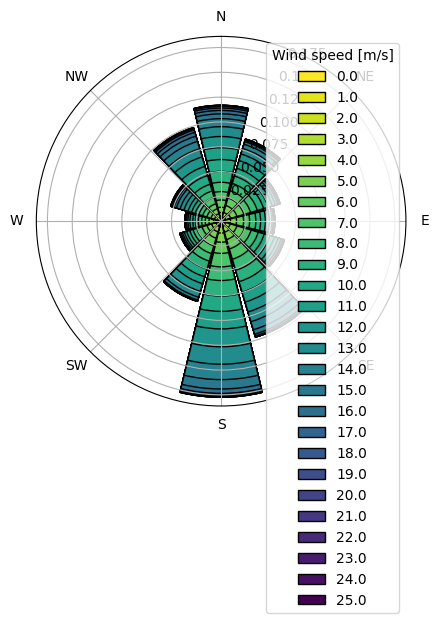

In [3]:
wind_rose_base = WindRose.read_csv_long(
    "../inputs/wind_rose.csv", wd_col="wd", ws_col="ws", freq_col="freq_val", ti_col_or_value=0.06
)

# Resample to number of sectors
wind_rose_base = wind_rose_base.aggregate(wd_step=360/num_sectors)

wind_rose_base.plot()

## Generate the other wind roses

Assume that the wind roses at other points are generated by rotating the wind rose as y increases increasing the velocity as x increases.

In [4]:
x_list = []
y_list = []
wind_rose_list = []
n_bins_per_step = 1
scale_factor = 0.4

for xi in range(Nx):
    for yi in range(Ny):    

        # Get the x and y locations for this point
        x = Xmin + xi * cell_size
        y = Ymin + yi * cell_size
        x_list.append(x)
        y_list.append(y)

        # Instantiate the wind rose object
        wind_rose = WindRose.read_csv_long(
            "../inputs/wind_rose.csv", wd_col="wd", ws_col="ws", freq_col="freq_val", ti_col_or_value=0.06
        )

        # Resample to number of sectors
        wind_rose = wind_rose.aggregate(wd_step=360/num_sectors)

        # Rotate the wind rose
        rotate_steps = yi * n_bins_per_step
        freq_table = wind_rose.freq_table.copy()
        freq_table_new = freq_table.copy()
        freq_table_new[rotate_steps:,:] = freq_table[0:freq_table.shape[0]-rotate_steps,:]
        freq_table_new[:rotate_steps,:] = freq_table[freq_table.shape[0]-rotate_steps:,:]

        # Scale the wind rose
        scale_vector = np.linspace(1-scale_factor * xi, 1+scale_factor *xi, freq_table.shape[1])
        
        # Slace freq_table_new using scale_vector along the wind speed axis
        freq_table_new = freq_table_new * scale_vector

        # Add to list
        wind_rose_list.append(WindRose(
            wind_directions=wind_rose.wind_directions,
            wind_speeds=wind_rose.wind_speeds,
            ti_table=wind_rose.ti_table,
            freq_table=freq_table_new))


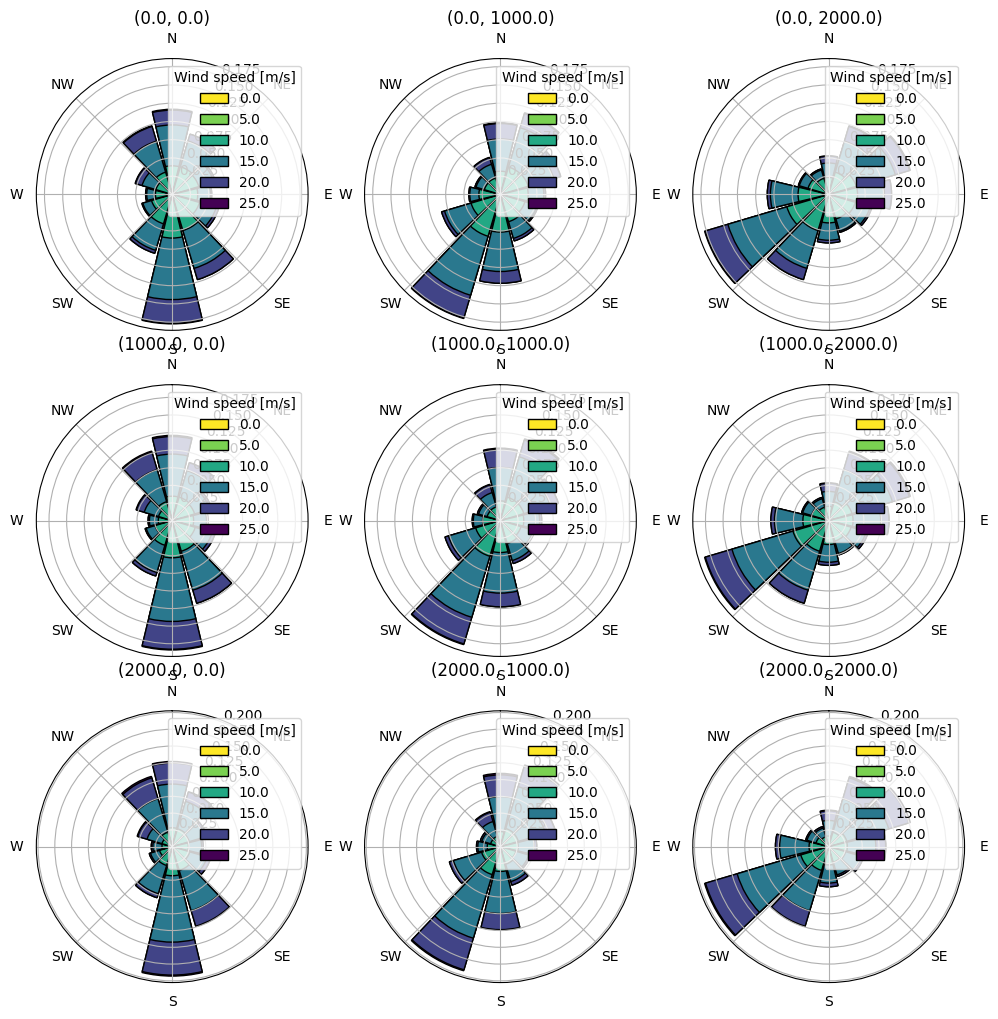

In [5]:
# Show the wind roses in a grid
fig, axarr = plt.subplots(Nx, Ny, figsize=(12, 12),subplot_kw={"polar": True})
axarr = axarr.flatten()

for i, wind_rose in enumerate(wind_rose_list):

    wind_rose.plot(ax=axarr[i], ws_step=5)
    axarr[i].set_title(f"({x_list[i]}, {y_list[i]})")

A: 10.601377093906066, k: 2.734403995194797


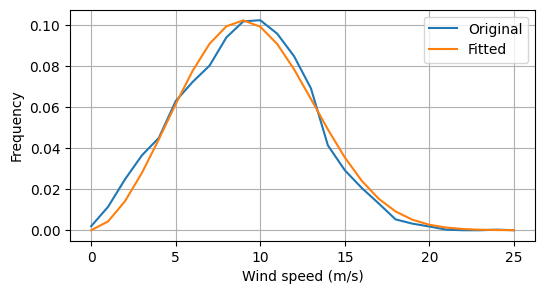

In [6]:
# Define a function given the distribution of wind speeds in one sector, compute the A and k parameters of the Weibull distribution
def weibull_func(U, A, k):
    return (k / A) * (U / A)**(k-1) * np.exp(-(U / A)**k)


def estimate_weibull(U, freq):

    # Normalize the frequency
    freq = freq / freq.sum()
   
    # Fit the Weibull distribution
    popt, _ = curve_fit(weibull_func, U, freq, p0=(6.0, 2.0))
    A_fit, k_fit = popt

    return A_fit, k_fit

freq_test =  wind_rose_list[0].freq_table[0,:] / wind_rose_list[0].freq_table[0,:].sum()
a_test,k_test = estimate_weibull(wind_rose_list[0].wind_speeds, freq_test)
print(f"A: {a_test}, k: {k_test}")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(wind_rose_list[0].wind_speeds,freq_test, label="Original")
ax.plot(wind_rose_list[0].wind_speeds, weibull_func(wind_rose_list[0].wind_speeds, a_test, k_test), label="Fitted")
ax.legend()
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Frequency")
ax.grid(True)

## Write out the WRG file

In [7]:
# Open the file 
with open("wrg_example.wrg", "w") as f:

    # Write the top line of the file
    f.write(f"{Nx} {Ny} {Xmin} {Ymin} {cell_size}\n")

    # Now loop over the points
    for i in range(Nx * Ny):

        # Initiate the line to write as 10 blank spaces
        line = "          "

        # Add the x-coodinate as a 10 character fixed width integer
        line = line + f"{int(x_list[i]):10d}"

        # Add the y-coodinate as a 10 character fixed width integer
        line = line + f"{int(y_list[i]):10d}"

        # Add the z-coodinate as a 10 character fixed width integer
        line = line + f"{int(z_coord):8d}"

        # Add the height above ground level as a 10 character fixed width integer
        line = line + f"{int(height_above_ground_level):5d}"
        
        # Get the wind rose for this point
        wind_rose = wind_rose_list[i]

        # Get the frequency matrix and wind speed
        freq_table = wind_rose.freq_table
        wind_speeds = wind_rose.wind_speeds
        wind_directions = wind_rose.wind_directions

        # Get the A and k parameters across all sectors
        freq_table_ws = freq_table.sum(axis=0)
        A, k = estimate_weibull(wind_speeds, freq_table_ws)

        # Write the A and k parameters
        line = line + f"{A:5.1f}{k:6.2f}"

        # Add place holder 0 for the power density
        line = line + f"{0:15d}"

        # Write the number of sectors
        line = line + f"{num_sectors:3d}"

        # Get the frequency table across wind directions
        freq_table_wd = freq_table.sum(axis=1)

        # Step through the sectors
        for wd_idx in range(num_sectors):

            # Write the probability for this sector
            line = line + f"{int(1000*freq_table_wd[wd_idx]):4d}"

            # Get the A and k parameters for this sector
            A, k = estimate_weibull(wind_speeds, freq_table[wd_idx,:])

            # Write the A and k parameters
            line = line + f"{int(A*10):4d}{int(k*100):5d}"
        
        # Write the line to the file
        f.write(line + "\n")


In [8]:
# Echo the file contents in this cell
with open("wrg_example.wrg", "r") as f:
    print(f.read())

3 3 0.0 0.0 1000.0
                   0         0       0   90  9.5  2.25              0 12 116 106  273  86  93  228  61  76  220  54  74  220  66  79  220 121  98  244 177 107  279  84  89  232  43  70  195  36  75  188  53 100  201  98 111  267
                   0      1000       0   90  9.5  2.25              0 12  98 111  267 116 106  273  86  93  228  61  76  220  54  74  220  66  79  220 121  98  244 177 107  279  84  89  232  43  70  195  36  75  188  53 100  201
                   0      2000       0   90  9.5  2.25              0 12  53 100  201  98 111  267 116 106  273  86  93  228  61  76  220  54  74  220  66  79  220 121  98  244 177 107  279  84  89  232  43  70  195  36  75  188
                1000         0       0   90 10.1  2.46              0 12 121 110  296  85  99  248  58  81  231  50  78  230  63  84  230 122 103  268 183 112  313  82  94  257  40  75  204  34  81  199  53 108  226 102 116  299
                1000      1000       0   90 10.1  2.46           